## Xception модели разпознавания deepfakes

In [1]:
#!c1.4
import os
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping

from keras.preprocessing import image
from keras.utils import to_categorical
from PIL import Image, ImageChops, ImageEnhance
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

from data_prepare.dataset_tools import extract_zip_with_cleanup, prepare_and_save_data
from data_prepare.plots import CommonPlot
from data_prepare.loaders import  DataLoader, XDataLoader
from data_prepare.models import ModelType, XFineTunedModel, XFeatureExtractorModel, FrameProcessor, XBaseAndCustomModel, XPureModel, NetPureModel, PersistModel


2025-05-22 18:09:05.596813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 18:09:05.597250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 18:09:05.599371: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 18:09:05.605119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747926545.615160  417806 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747926545.61

In [2]:
IMAGE_ARCHIVE_PATH="data/celeb/v1/"
MODELS_DIR = "models"
RESULTS_DIR = "results"
MODEL_TYPE=ModelType.XCEPTION
DATASET_OUTPUT_DIR='data/dataset'
LEARNING_RATE=1e-4
FEATURE_DIM=512
print("Done")

Done


#### Подготовка данных 

In [3]:
data_loader = XDataLoader(IMAGE_ARCHIVE_PATH)
train_gen, val_gen, test_gen = data_loader.load_genrators()
print("Done", train_gen, val_gen, test_gen)

data/celeb/v1/fake data/celeb/v1/real
data/dataset/x/train data/dataset/x/val data/dataset/x/test
Found 88 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 54 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}
Train samples: 88
Validation samples: 61
Test samples: 54
Done <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7d96d377eff0> <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7d96d3a578c0> <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7d96d42e6cc0>


#### Feature extractor model

In [8]:
feature_model = XFeatureExtractorModel()
feature_model.predict(train_gen)

/home/alvantor/opt/anaconda3/envs/deepfakedetection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step


array([[0.        , 0.17005944, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.15397371, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09357488],
       ...,
       [0.        , 0.555544  , 0.08265894, ..., 0.        , 0.        ,
        0.00675719],
       [0.        , 0.37797716, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04367494,
        0.        ]], dtype=float32)

In [10]:
trained_model.save("xception_deepfake_model.h5")

### 1. Pure model

#### Xception model

In [4]:
pure_model = PersistModel(XPureModel(MODELS_DIR, RESULTS_DIR))

TypeError: XPureModel.__init__() missing 1 required positional argument: 'results_dir'

In [6]:
_, pure_history = pure_model.fit(train_gen, val_gen, 1)

Persist fitting run
Pure fitting run


/home/alvantor/opt/anaconda3/envs/deepfakedetection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - auc: 0.5666 - loss: 0.7035 - precision: 0.2950 - recall: 0.5363  

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - auc: 0.5741 - loss: 0.6913 - precision: 0.3046 - recall: 0.5226 - val_auc: 0.7392 - val_loss: 0.6840 - val_precision: 0.5652 - val_recall: 0.4333


AttributeError: 'PersistModel' object has no attribute '_results_dir'

In [ ]:
pure_model.load_trained_model()

In [ ]:
y_pred = pure_model.predict(test_gen)

In [ ]:
test_loss, test_precision, test_recall, test_auc = pure._model.evaluate(test_gen)

#### Analyze results

In [13]:
plots = CommonPlot(pure_model)
plots.plot(test_gen)

FileNotFoundError: [Errno 2] No such file or directory: 'results/xpure/y_pred.csv'

#### EfficientNet model

In [4]:
net_pure_model = NetPureModel(MODELS_DIR, RESULTS_DIR)

NetPure model run


2025-05-21 10:46:24.080336: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Pure model run


In [ ]:
_, net_pure_history = net_pure_model.fit(train_gen, val_gen, 3)

In [ ]:
y_pred = net_pure_model.predict(test_gen)

In [ ]:
test_loss, test_precision, test_recall, test_auc = net_pure_model._model.evaluate(test_gen)

#### Analyze results

In [ ]:
plots = CommonPlot(net_pure_model)
plots.plot(test_gen)

### 2. Fine tuned model

In [5]:
finetune_model = XFineTunedModel(MODELS_DIR, RESULTS_DIR)

Pure model run


In [7]:
_, finetune_history = finetune_model.fit(train_gen, val_gen, 1, 0)

/Users/aleksandr/opt/anaconda3/envs/deepfakedetection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/284 ━━━━━━━━━━━━━━━━━━━━ 54:23 12s/step - auc: 0.6172 - loss: 0.7453 - precision: 0.2500 - recall: 0.8750

KeyboardInterrupt: 

In [ ]:
y_pred = finetune_trained_model.predict(test_gen)

In [8]:
#!gt4.1
finetune_trained_model = finetune.load_trained_model()
test_loss, test_precision, test_recall, test_auc = finetune_trained_model.evaluate(test_gen)

print(f"\nTest AUC: {test_auc:.4f}, loss: {test_loss:.4f}, pression: {test_precision:.4f}, recall: {test_recall:4f}")

2025-05-02 09:55:15.198383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Analyze results for finetuned model

In [9]:
plots = CommonPlot(finetune_model)

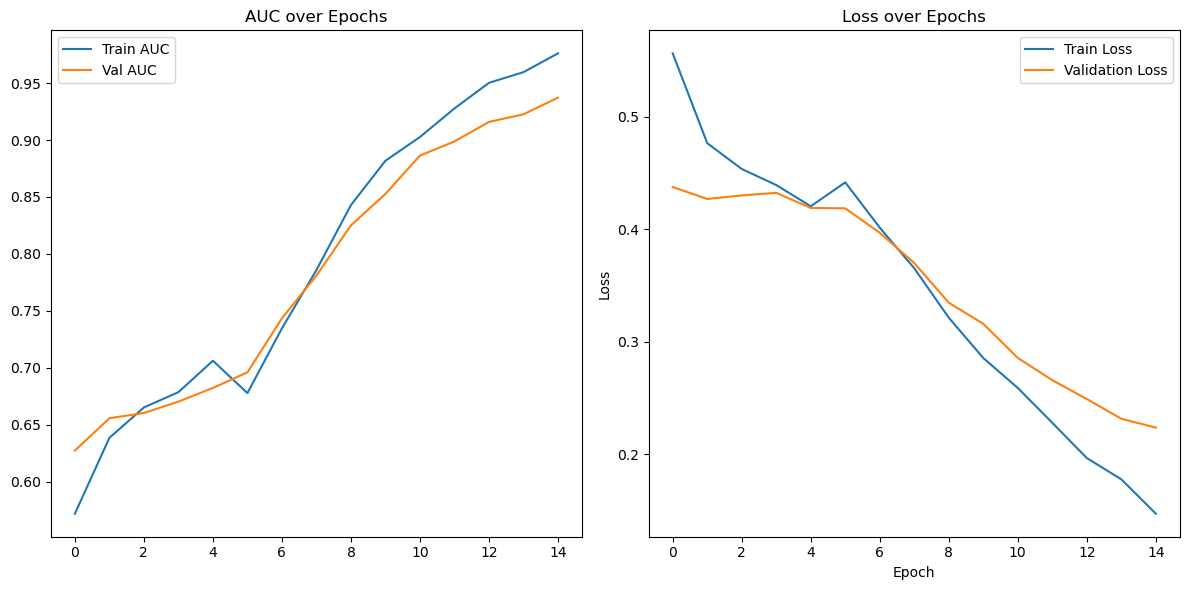

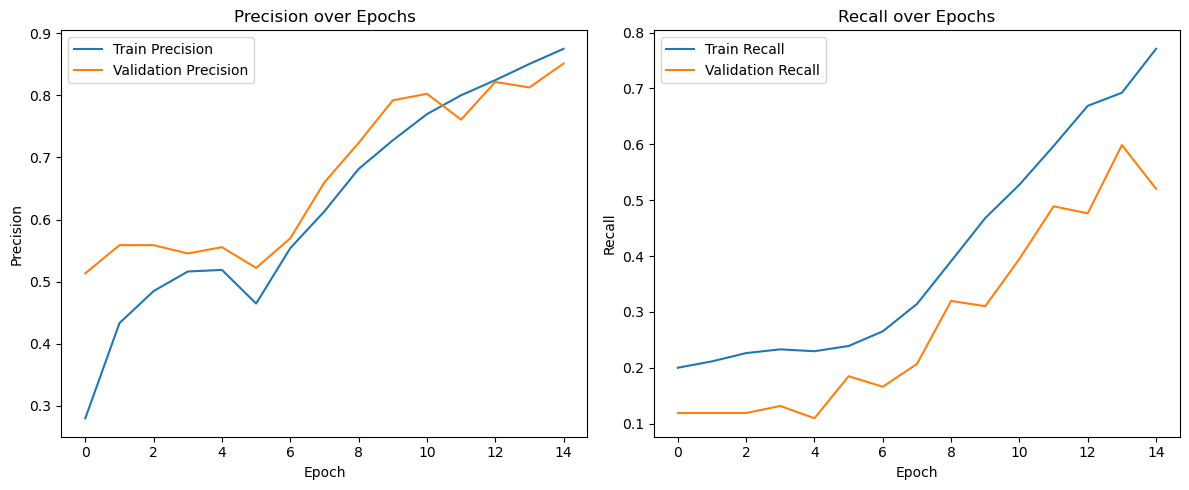

<Figure size 640x480 with 0 Axes>

ValueError: Found input variables with inconsistent numbers of samples: [1947, 1946]

In [10]:
plots.plot(test_gen)

### 3. Custom model fitting

In [4]:
xbase_model = XBaseAndCustomModel(MODELS_DIR)

2025-05-20 19:36:19.791771: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/alvantor/opt/anaconda3/envs/deepfakedetection/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
pure_finetuned_model_history_df = pd.DataFrame(pure_finetuned_model_histories)
pure_finetuned_model_history_df.to_csv('results/pure/pure_finetuned_history.csv', index=False)

In [11]:
pure_finetune_model_dir = os.path.join(MODELS_DIR, 'xception_finetune_deepfake_model.h5')
pure_finetune_model = tf.keras.models.load_model(pure_finetune_model_dir)
y_pred = pure_finetune_model.predict(test_gen)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.to_csv('results/pure/y_pred.csv', index=False)

2025-05-07 19:43:05.404547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900


61/61 [==============================] - 27s 249ms/step


In [17]:
pure_finetuned_model.evaluate(test_gen)

10/10 [==============================] - 2s 204ms/step - loss: 0.6840 - precision: 1.0000 - recall: 0.6344 - auc: 0.0000e+00


[0.6839633584022522, 1.0, 0.6343749761581421, 0.0]

#### Analyze results for pure model

In [6]:
y_pred = pd.read_csv('results/pure/y_pred.csv')
y_true = test_gen.labels

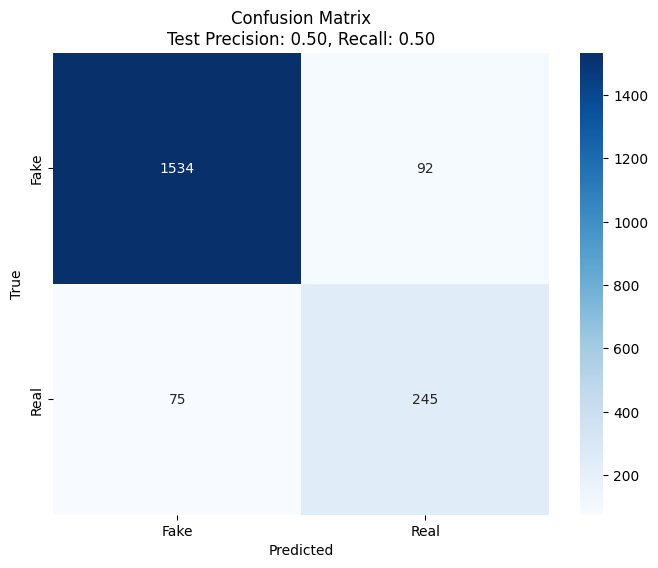

In [7]:
confusion_matrix_plot(y_pred, y_true, 0.5, 0.5)

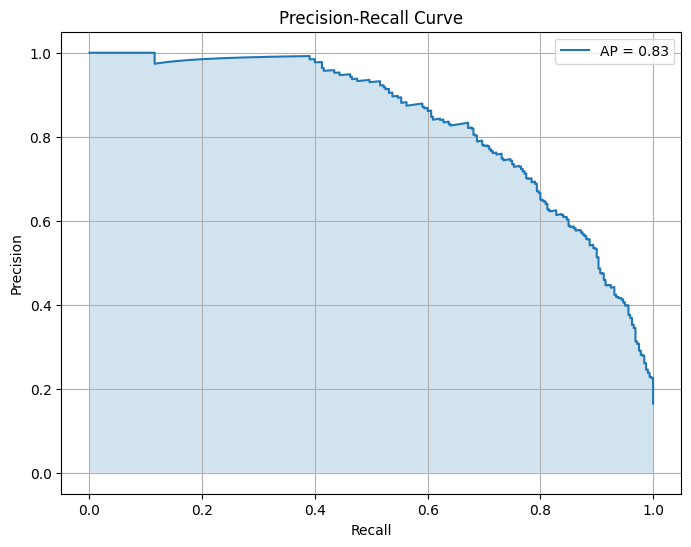

In [8]:
precision_recall_plot(y_true, y_pred)

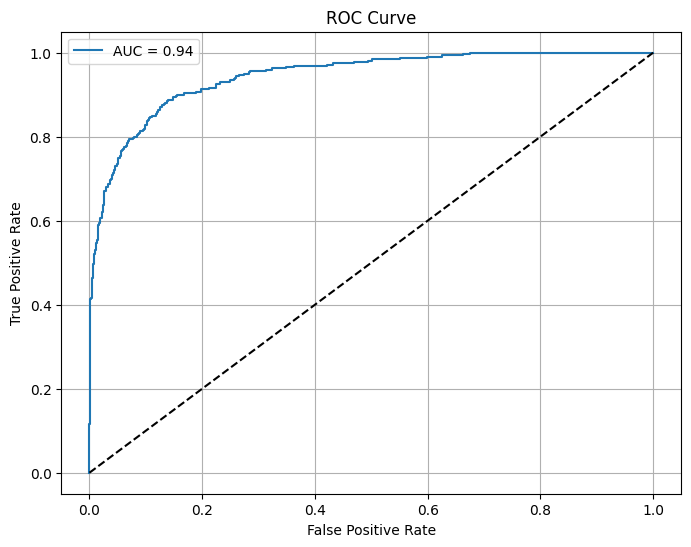

In [9]:
roc_plot(y_true, y_pred)